In [108]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import os as io
from PIL import Image as im
import torch.nn as nn
import torch.optim as optim

import torch
import copy
import os 
from pathlib import Path
import matplotlib.pyplot as plt

In [109]:
class CustomDatasets(Dataset):
    """Classifier dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be appliedon a sample.
        """
        self.data = self.get_data(csv_file)
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.X_train = self.data['filename']
        self.y_train  = torch.tensor(self.data['label'], dtype=torch.long)
        
    def get_data(self, csv):
        """Return dataframe
        csv: path to csv file
        """
        df = pd.read_csv(csv)
        # check if columns exist.
        name_column = True if set(['filename', 'label']).issubset(df.columns) else False
        if name_column:
            return df[['filename', 'label']]
        else: 
            raise ValueError('EL nombre de las columnas se deben llamar filename y label')
        
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_name = self.root_dir.joinpath(self.X_train[index])
        image = im.open(img_name).convert('RGB')
        label = self.y_train[index]

        if self.transform:
            image = self.transform(image)

        return image, label

data_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        
    ])



def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [110]:
tranform_datasets = CustomDatasets(csv_file='/Users/ezapata/Downloads/metadata-ejemplo.csv',
                                 root_dir='/Users/ezapata/Downloads/Ejemplo/', transform=train_tranform)


In [129]:
from sklearn.model_selection import train_test_split
df = pd.read_csv('/Users/ezapata/Downloads/metadata-ejemplo.csv')
train, test = train_test_split(df, test_size=0.30, random_state=42)

In [130]:
train.shape, test.shape

((21, 4), (9, 4))

### Split Datasets 

In [120]:
def split_datasets(dataset, train=.7, val=.3, test=False, shuffle=True):
    size = len(dataset)
    indx = list(range(size))
    split = int(np.floor(val * size))
    if shuffle:
        np.random.seed(42)
        np.random.shuffle(indx)
    train_indices, val_indices = indices[split:], indices[:split]
    # Creating train val sampler
    train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    valid_sampler = torch.utils.data.SubsetRandomSampler(val_indices)
    
    return train_sampler, valid_sampler

label_names = [
    '0',
    '1',
    '2',
    '3',
]
def plot_images(images, cls_true, cls_pred=None):
    """
    Adapted from https://github.com/Hvass-Labs/TensorFlow-Tutorials/
    """
    fig, axes = plt.subplots(2, 2)
    for i, ax in enumerate(axes.flat):
        # plot img
        ax.imshow(images[i, :, :, :], interpolation='spline16')

        # show true & predicted classes
        cls_true_name = label_names[cls_true[i]]
        if cls_pred is None:
            xlabel = "{0} ({1})".format(cls_true_name, cls_true[i])
        else:
            cls_pred_name = label_names[cls_pred[i]]
            xlabel = "True: {0}\nPred: {1}".format(
                cls_true_name, cls_pred_name
            )
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

In [114]:
train_sample, val_sample = split_datasets(tranform_datasets)

train_dataloader = DataLoader(tranform_datasets, batch_size=4, 
                             num_workers=1, sampler=train_sample)

val_dataloader = DataLoader(tranform_datasets, batch_size=4, 
                             num_workers=1, sampler=val_sample)

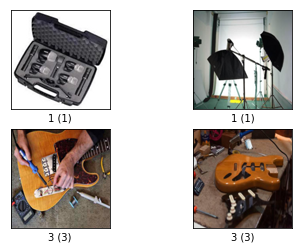

In [123]:
data_iter = iter(train_dataloader)
images, labels = data_iter.next()
X = images.numpy().transpose([0, 2, 3, 1])
plot_images(X, labels)

In [100]:
for x , y in val_dataloader:
    print(y)

tensor([1, 2, 2, 3])
tensor([1, 3, 2, 1])
tensor([3])


In [9]:
resnet_model = models.resnet18(pretrained=True)
# freeze
set_parameter_requires_grad(resnet_model, True)
num_features = resnet_model.fc.in_features

In [10]:
num_clases = 4

In [11]:
resnet_model.fc = nn.Linear(num_features, num_clases)
input_size = 224
opt = optim.Adam(resnet_model.parameters(), lr=3e-3)
loss = nn.CrossEntropyLoss()

In [12]:
def train(num_epochs, model, opt, loss_fn, dataloaders):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        model.train()

        running_loss = 0.0
        running_corrects = 0
         # Iterate over data.
            
        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)

            loss = loss_fn(outputs, labels)
            loss.backward() # backprop
            opt.step() 
            opt.zero_grad()
    
            
            _, preds = torch.max(outputs, 1)
            train_loss += loss.item() * len(inputs)
        

         # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        
        print('{} Loss: {} Acc: {}'.format('phase', epoch_loss, 'n'))
         



In [13]:
train(2, resnet_model, opt, loss, dataloader)

Epoch 0/1
----------
phase Loss: 0.09726513226826985 Acc: n
Epoch 1/1
----------
phase Loss: 0.08752926190694173 Acc: n
